# Классификация анимационных проектов
Студия мультфильмов собирает статистику для оценки популярности различных проектов. И важно агрегировать данные по проектам, а не по отдельным роликам – агрегация статистики по проектам помогает принимать обоснованные бизнес-решения и увеличивать успех новых проектов 👍

Нужно создать автоматизированное решение для определения принадлежности видеороликов к проектам на основе анализа текстового описания, субтитров и другой доступной информации.

- Тексты могут быть на разных языках, содержать ошибки и опечатки, а также иногда отсутствовать
- Ролики одного проекта могут размещаться на разных каналах
- Можно с помощью Youtube API использовать дополнительную информацию, но к сожалению не все ролики могут быть обогащены данными (например, лайвы и закрытые каналы)

При разработке постарайтесь не только максимизировать метрику, но и создать наиболее гибкое и масштабируемое решение по возможности без ручной разметки 😉

## Описание колонок
- `date` дата, когда ролик появился на ютубе
- `reel_name` название ролика
- `yt_reel_id` уникальный идентификатор ролика на ютубе
- `cartoon` название проекта, целевая переменная
- `url` ссылка на ролик (включает идентификатор)
- `text` текст сниппета, включает название ролика и описание
- `seconds` длительность
- `is_shorts` вертикальные видеоролики продолжительностью <60сек
- `broadcast` лайвы, прямые эфиры
- `yt_channel_id` идентификатор ютуб канала
- `yt_channel_name` название ютуб канала
- `yt_ch_url` ссылка на ютуб канал
- `yt_channel_type` тип канала (Мультфильмы, Детские, Блогеры, Shorts…)
- `flag_closed` ютуб канал закрыт, если 1
- `international` метка международных каналов, каналов на иностранном языке (переведенный контент)
- `language` язык

# Импорт и загрузка данных

In [1]:
%%capture
!pip install transformers datasets accelerate

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, pipeline
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%cd /kaggle/input/animation-reels-classification

/kaggle/input/animation-reels-classification


In [5]:
train_df = pd.read_csv("train.csv", lineterminator='\n')
test_df = pd.read_csv("test.csv", lineterminator='\n')

# Обзор данных

In [6]:
print('train.csv')
train_df.info()
print('-'*50)
print('test.csv')
test_df.info()

train.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83411 entries, 0 to 83410
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             83411 non-null  object 
 1   reel_name        83408 non-null  object 
 2   yt_reel_id       83411 non-null  object 
 3   cartoon          83411 non-null  object 
 4   url              83411 non-null  object 
 5   text             83411 non-null  object 
 6   seconds          74653 non-null  float64
 7   is_shorts        74653 non-null  float64
 8   broadcast        74653 non-null  object 
 9   yt_channel_id    83366 non-null  object 
 10  yt_channel_name  83363 non-null  object 
 11  yt_ch_url        83363 non-null  object 
 12  yt_channel_type  83363 non-null  object 
 13  flag_closed      83363 non-null  float64
 14  international    83363 non-null  float64
 15  language         497 non-null    object 
dtypes: float64(4), object(12)
memory usage: 10.2+ MB

In [7]:
train_df.head()

,date,reel_name,yt_reel_id,cartoon,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
0,2023-12-30,100 подарков и только один можно оставить себе,PyGZL_fCbSc,none,https://www.youtube.com/watch?v=PyGZL_fCbSc,[100 подарков и только один можно оставить себе],1854.0,0.0,none,UCcartHVtvAUzfajflyeT_Gg,Miss Katy,https://www.youtube.com/channel/UCcartHVtvAUzf...,Блогеры,0.0,0.0,NaN
1,2018-06-29,ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ F...,Lcp0pFZF4eQ,none,https://www.youtube.com/watch?v=Lcp0pFZF4eQ,[ЗАБАГАЛИ Лизу в Реальной Жизни АРТУР и НАСТЯ ...,602.0,0.0,none,UCWI7puXzGTPuxsoW2HD3XxQ,Boys and Toys,https://youtube.com/channel/UCWI7puXzGTPuxsoW2...,Блогеры,0.0,0.0,NaN
2,2023-11-26,Грозная семейка Лучшие СЕСТРИНСКИЕ моменты с...,z8d6LbiBRnk,none,https://www.youtube.com/watch?v=z8d6LbiBRnk,[Грозная семейка Лучшие СЕСТРИНСКИЕ моменты ...,3604.0,0.0,none,UCw3vK8lNe5SZzL--rMgq-CQ,Nickelodeon_Cyrillic,https://youtube.com/channel/UCw3vK8lNe5SZzL--r...,Мультфильмы,0.0,0.0,NaN
3,2016-05-30,Как сделать ожерелье из ткани своими руками,0iu0p_Y8DjM,none,https://www.youtube.com/watch?v=0iu0p_Y8DjM,[Как сделать ожерелье из ткани своими руками] ...,264.0,0.0,none,UCq1JpGFxcZTbbOAz010U-og,Трум Трум,https://youtube.com/channel/UCq1JpGFxcZTbbOAz0...,Блогеры,0.0,0.0,NaN
4,2023-07-06,Sleepover Rules Om Nom Stories Cartoon for k...,rYwOVp_Edjw,none,https://www.youtube.com/watch?v=rYwOVp_Edjw,[Sleepover Rules Om Nom Stories Cartoon for ...,42899.0,0.0,none,UCniI-BQk7qAtXNmmz40LSdg,Kedoo Toons TV Funny Animations,https://youtube.com/channel/UCniI-BQk7qAtXNmmz...,Мультфильмы,0.0,0.0,NaN


In [8]:
test_df.head()

,date,reel_name,yt_reel_id,url,text,seconds,is_shorts,broadcast,yt_channel_id,yt_channel_name,yt_ch_url,yt_channel_type,flag_closed,international,language
0,2020-10-26,пять маленьких монстров хэллоуин рифмы потеш...,RBw4j0aMWyM,https://www.youtube.com/watch?v=RBw4j0aMWyM,[пять маленьких монстров хэллоуин рифмы поте...,960.0,0.0,none,UCfeljpDR__qqp-lLBJdiQkw,Kids Tv Russia песенки для дете,https://youtube.com/channel/UCfeljpDR__qqp-lLB...,Детские,0.0,0.0,NaN
1,2024-03-24,Tractor mini Bulldozer to making concrete road...,5wTfpmlZe5k,https://www.youtube.com/watch?v=5wTfpmlZe5k,[Tractor mini Bulldozer to making concrete roa...,0.0,0.0,live,UCIDMp2rLX4G5C6eiypl9SFA,OneDayAlex,https://www.youtube.com/channel/UCIDMp2rLX4G5C...,Блогеры,0.0,0.0,NaN
2,2020-06-28,Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челлендж,Fd9YA-oDjSo,https://www.youtube.com/watch?v=Fd9YA-oDjSo,[Кто Последний ПЕРЕСТАНЕТ Ехать Выиграл Челле...,1599.0,0.0,none,UC2tsySbe9TNrI-xh2lximHA,A4,https://youtube.com/channel/UC2tsySbe9TNrI-xh2...,Блогеры,0.0,0.0,NaN
3,2018-07-27,Мультики про машинки и паровозики для детей. Р...,NXCHY_J-5v0,https://www.youtube.com/watch?v=NXCHY_J-5v0,[Мультики про машинки и паровозики для детей. ...,467.0,0.0,none,UC_J_9-qRfVtKIkq7SxxVbhQ,ТВ Деткам,https://youtube.com/channel/UC_J_9-qRfVtKIkq7S...,Детские,0.0,0.0,NaN
4,2021-04-03,СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТОЛ...,XM-GRekoYzs,https://www.youtube.com/watch?v=XM-GRekoYzs,[СЛИШКОМ МАЛЕНЬКИЙ ПОРТАЛ В ЭНД В МАЙНКРАФТ ТО...,364.0,0.0,none,UCSmqZkD74x3TLt6eRM5GhTg,Dargas,https://youtube.com/channel/UCSmqZkD74x3TLt6eR...,Блогеры,0.0,0.0,NaN


## Пропуски

In [9]:
train_df.isna().sum()

date                   0
reel_name              3
yt_reel_id             0
cartoon                0
url                    0
text                   0
seconds             8758
is_shorts           8758
broadcast           8758
yt_channel_id         45
yt_channel_name       48
yt_ch_url             48
yt_channel_type       48
flag_closed           48
international         48
language           82914
dtype: int64

In [10]:
test_df.isna().sum()

date                   0
reel_name              3
yt_reel_id             0
url                    0
text                   0
seconds             5801
is_shorts           5801
broadcast           5801
yt_channel_id         24
yt_channel_name       28
yt_ch_url             28
yt_channel_type       28
flag_closed           28
international         28
language           55271
dtype: int64

Много пропусков в `seconds`, `is_shorts` и `broadcast`. Почти везде отсутствует `language`. Везде есть `date`, `yt_reel_id`, `url` и `text`. Целевой признак `cartoon` также без пропусков.

Как обработать пропуски я решу после анализа, на этапе предобработки.

## Дубликаты

In [11]:
train_df.yt_reel_id.duplicated().sum(), test_df.yt_reel_id.duplicated().sum()

(0, 0)

In [12]:
train_df.drop('yt_reel_id', axis=1).duplicated().sum(), test_df.drop('yt_reel_id', axis=1).duplicated().sum()

(0, 0)

Явных дубликатов id или фичей не обнаружено

# Анализ данных

Уникальные значения категориальных признаков:

In [13]:
for col in ['broadcast', 'yt_channel_type', 'language']:
    print(col)
    train = train_df[col].dropna().unique()
    print('    train:', len(train), sorted(train))
    test = test_df[col].dropna().unique()
    print('     test:', len(test), sorted(test))

broadcast
    train: 3 ['live', 'none', 'upcoming']
     test: 3 ['live', 'none', 'upcoming']
yt_channel_type
    train: 4 ['Shorts', 'Блогеры', 'Детские', 'Мультфильмы']
     test: 4 ['Shorts', 'Блогеры', 'Детские', 'Мультфильмы']
language
    train: 3 ['arabic', 'english', 'spanish']
     test: 3 ['arabic', 'english', 'spanish']


Количество классов в целевом признаке:

In [14]:
train_df.cartoon.nunique()

45

In [15]:
def count_proportion(data):
    return pd.DataFrame({'count': data.value_counts(), 'proportion': data.value_counts(normalize=True)})

Распределение целевого признака (`cartoon`):

In [16]:
count_proportion(train_df.cartoon).head(10)

,count,proportion
cartoon,,
none,78231,0.937898
Маша и медведь,853,0.010226
Говорящий Том,589,0.007061
Буба,529,0.006342
Кошечки собачки,437,0.005239
Енотки,379,0.004544
Бэтмен,353,0.004232
ЖилаБыла Царевна,229,0.002745
Оранжевая корова,227,0.002721


Почти 0.94 это "none", т.е. неотслеживаемые проекты. Нужно посмотреть что можно сделать с таким дисбалансом

Распределение `broadcast`:

In [17]:
count_proportion(train_df.broadcast)

,count,proportion
broadcast,,
none,72856,0.975929
live,1682,0.022531
upcoming,115,0.001540


<Axes: xlabel='broadcast', ylabel='count'>

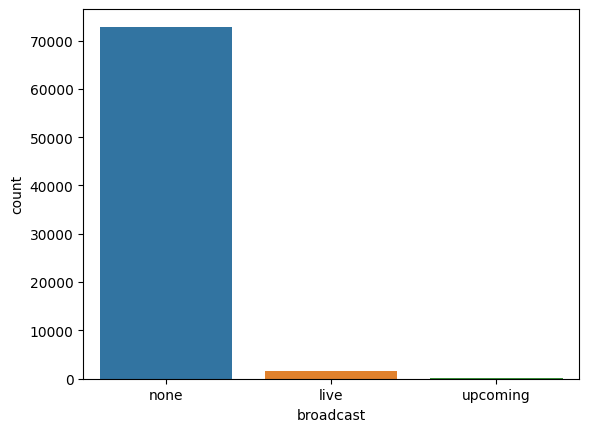

In [18]:
sns.countplot(train_df, x='broadcast')

Заметна достаточно низкая вариативность у признака. Можно отбросить как мало значимый

Распределение `yt_channel_type`:

In [19]:
count_proportion(train_df.yt_channel_type)

,count,proportion
yt_channel_type,,
Мультфильмы,40627,0.487351
Блогеры,32905,0.394719
Детские,9608,0.115255
Shorts,223,0.002675


<Axes: xlabel='yt_channel_type', ylabel='count'>

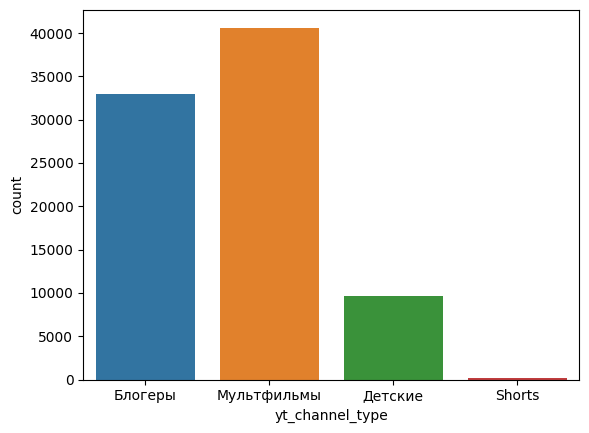

In [20]:
sns.countplot(train_df, x='yt_channel_type')

Потенциально можно использовать признак для обучения, хотя непонятно есть ли корреляция с каким либо конкретным проектом

Распределение `language`:

In [21]:
count_proportion(train_df.language.fillna('unknown'))

,count,proportion
language,,
unknown,82914,0.994042
english,204,0.002446
spanish,201,0.002410
arabic,92,0.001103


<Axes: xlabel='language', ylabel='count'>

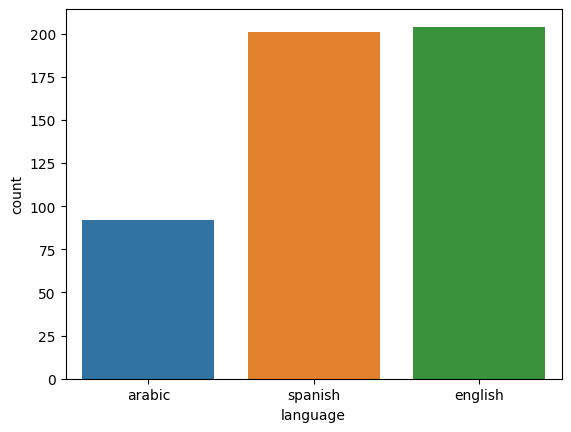

In [22]:
sns.countplot(train_df, x='language')

Более 0.99 значений отсутствуют. Можно попробовать выявить язык из описания или отбросить

Распределение каналов (`yt_channel_name`):

In [23]:
count_proportion(train_df.yt_channel_name).head(10)

,count,proportion
yt_channel_name,,
Kedoo Toons TV Funny Animations,2442,0.029294
Guka Family Show,2264,0.027158
Теремок ТВ,2137,0.025635
Super Senya RU,1767,0.021196
Get Movies,1654,0.019841
ДиДи ТВ,1626,0.019505
Трум Трум,1625,0.019493
Аид VyacheslavOO,1558,0.018689
Мульт,1419,0.017022


Ролики примерно равномерно распределены по каналам. Id или название канала можно использовать для обучения

Распределение длительности (`seconds`):

In [24]:
train_df.seconds.describe()

count     74653.000000
mean       1921.289084
std        7097.896248
min           0.000000
25%         200.000000
50%         602.000000
75%        1316.000000
max      504055.000000
Name: seconds, dtype: float64

(0.0, 5580.864035600829)

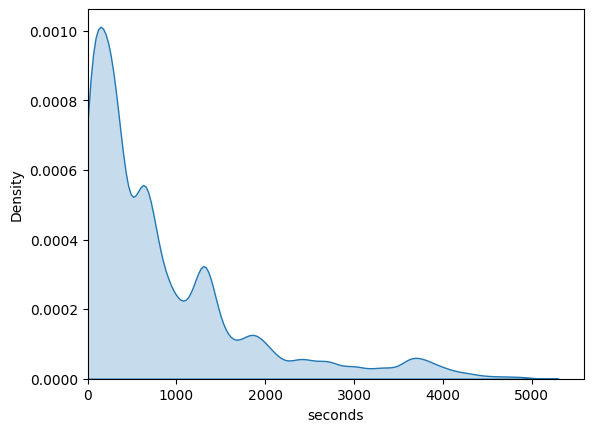

In [25]:
sns.kdeplot(train_df[train_df.seconds<5000], x='seconds', fill=True)
plt.xlim(0)

In [26]:
train_df.groupby('is_shorts').seconds.describe()

,count,mean,std,min,25%,50%,75%,max
is_shorts,,,,,,,,
0.0,70844.0,2023.129919,7272.250019,0.0,239.0,624.0,1352.0,504055.0
1.0,3809.0,27.140457,15.023073,1.0,15.0,24.0,37.0,60.0


(0.0, 5586.492541172209)

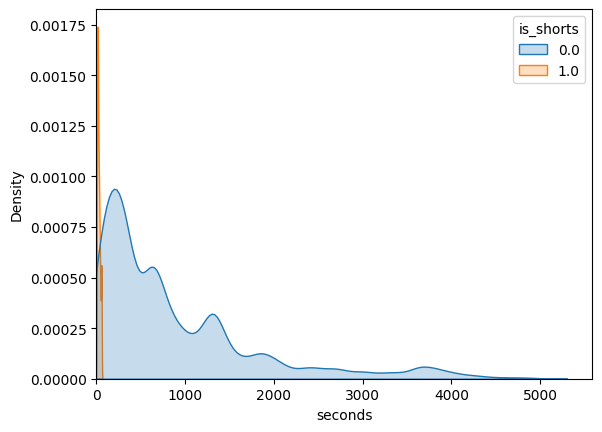

In [27]:
sns.kdeplot(train_df[train_df.seconds<5000], x='seconds', hue='is_shorts', fill=True)
plt.xlim(0)

# Предобработка

В качестве базовой модели я взял `distilbert-base-multilingual-cased`.

В качестве признака я оставил только строку в формате `"Название канала [Название ролика] Описание ролика"`.

In [28]:
checkpoint = 'distilbert/distilbert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [29]:
def make_dataset(df):
    def transform(x):
        res = {'input': f'{x.yt_channel_name} {x.text}',
               'id': x.yt_reel_id}
        if hasattr(x, 'cartoon'):
            res['label'] = x.cartoon
        return res
    def tokenize(x):
        return tokenizer(x['input'], truncation=True)

    df = df.apply(transform, axis=1, result_type='expand')
    ds = Dataset.from_pandas(df)
    ds = ds.map(tokenize, batched=True)
    if 'label' in ds.column_names:
        ds = ds.class_encode_column('label')
    return ds

def compute_metrics(eval_pred):
    p, y = eval_pred
    p = np.argmax(p, axis=1)
    return {'accuracy': accuracy_score(y, p), 'f1': f1_score(y, p, average='macro')}

In [30]:
dataset = make_dataset(train_df).train_test_split(test_size=0.2, seed=42, stratify_by_column='label')
dataset['eval'] = dataset['test']
dataset['test'] = make_dataset(test_df)

Map:   0%|          | 0/83411 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/83411 [00:00<?, ? examples/s]

Map:   0%|          | 0/55608 [00:00<?, ? examples/s]

# Обучение

In [31]:
labels = dataset['train'].features['label']
num_labels = labels.num_classes
id2label = {labels.str2int(n): n for n in labels.names}
label2id = {n: i for i, n in id2label.items()}

In [32]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels, id2label=id2label, label2id=label2id)

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
training_args = TrainingArguments(
    output_dir='/kaggle/working/reels-clf',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=6,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    report_to='none',
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['eval'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [34]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.095700,0.080470,0.989690,0.389412
2,0.074000,0.068982,0.993706,0.524608
3,0.056500,0.077407,0.994725,0.576372
4,0.034700,0.065171,0.995504,0.677795
5,0.026900,0.064203,0.995624,0.742268
6,0.021300,0.061533,0.995744,0.789990


TrainOutput(global_step=6258, training_loss=0.06588175110864197, metrics={'train_runtime': 10762.3996, 'train_samples_per_second': 37.201, 'train_steps_per_second': 0.581, 'total_flos': 5.307637757681664e+16, 'train_loss': 0.06588175110864197, 'epoch': 6.0})

В итоге получилась модель с f1 = 0.79

Скорее всего можно ещё улучшить результат, если объединить результаты обработки текста с моделью, которая использует табличные данные.

# Тестирование

In [35]:
predictions = trainer.predict(dataset['test'])

In [43]:
%cd /kaggle/working

/kaggle/working


In [44]:
out = pd.DataFrame({
    'yt_reel_id': dataset['test']['id'],
    'cartoon': labels.int2str(np.argmax(predictions.predictions, axis=1))
})
out.to_csv('submission.csv', index=False)